In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re

import numpy as np

In [3]:

df_stats = pd.read_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_estadisticas.csv")

empresas_equivalentes = {
    "AUSTRAL GROUP SAA": "AUSTRAL GROUP SAA",
    "CFG-COPEINCA": "COPEINCA",
    "HAYDUK": "HAYDUK",
    "TASA": "TASA",
    "TASA ": "TASA",
    "PESQUERA CENTINELA S.A.C": "CENTINELA S.A.C",
    "CENTINELA": "CENTINELA S.A.C",
    "PESQUERA DIAMANTE S.A.": "DIAMANTE S.A.",
    "DIAMANTE": "DIAMANTE S.A.",
    "Pesquera Diamante S.A.": "DIAMANTE S.A.",
    "PESQUERA EXALMAR S.A.A.": "EXALMAR S.A.A.",
    "CAPRICORNIO": "CAPRICORNIO",
    "INVERSIONES QUIAZA SAC": "INVERSIONES QUIAZA SAC",
    "QUIAZA": "INVERSIONES QUIAZA SAC",
    "PESQ. ISA": "ISA",
    "LOS HALCONES SA": "LOS HALCONES SA",
    "LOS HALCONES": "LOS HALCONES SA",
    "Inversiones Eccola": "INVERSIONES ECCOLA",
    "INVERSIONES ECCOLA": "INVERSIONES ECCOLA",
    "PESQ. NINFAS DEL MAR": " NINFAS DEL MAR",
    "PESQ. MAJAT": "MAJAT",
    "PESQUERA LUCIANA SAC": "LUCIANA SAC",
    "PESQUERA SKAVOS S.A.C.": "SKAVOS S.A.C."
}

df_stats["empresa_normalizada"] = df_stats["empresa"].replace(empresas_equivalentes)


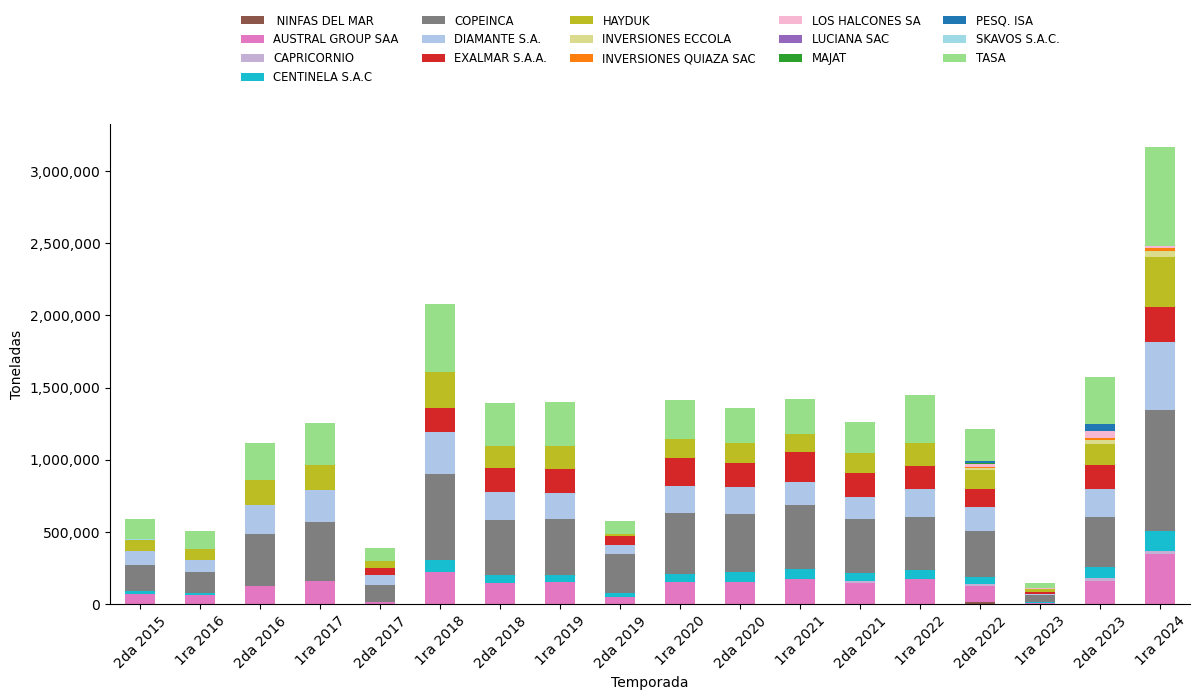

In [4]:
def ordenar_temporadas(etiqueta):
    """
    Convierte '1ra 2016' o '2da 2016' en un número ordenable.
    Ejemplo: '1ra 2016' -> 2016.0, '2da 2016' -> 2016.5
    """
    match = re.match(r"(1ra|2da)\s*(\d{4})", etiqueta)
    if match:
        temporada, anio = match.groups()
        return int(anio) + (0 if temporada == "1ra" else 0.5)
    return float('inf')



pivot_empresas = df_stats.pivot_table(
    index="temporada",
    columns="empresa_normalizada",
    values="volumen_empresa_tm",
    aggfunc="sum",
    fill_value=0,
)

orden = sorted(pivot_empresas.index, key=ordenar_temporadas)
pivot_empresas = pivot_empresas.loc[orden]


cmap = plt.colormaps["tab20"]
colors = cmap(np.linspace(0, 1, pivot_empresas.shape[1]))
np.random.shuffle(colors)


fig = plt.figure(figsize=(12, 6))
ax = plt.axes([0.05, 0.05, 0.9, 0.8])
pivot_empresas.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_ylabel("Toneladas")
# ax.set_title("Participación de empresas por temporada", loc='left')
ax.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=5, fontsize='small', frameon=False)
ax.set_xlabel("Temporada")
ax.set_xticks(range(len(orden)))
ax.set_xticklabels(orden, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

In [5]:
df_stats["anio"] = df_stats["temporada"].str.extract(r"(\d{4})").astype(int)
df_stats["tipo_temporada"] = df_stats["temporada"].str.extract(r"(1ra|2da)")

totales_por_temporada = (
    df_stats.groupby(["empresa_normalizada", "temporada", "tipo_temporada"])["volumen_empresa_tm"]
    .sum()
    .reset_index()
)

promedios_empresas = (
    totales_por_temporada.groupby(["empresa_normalizada", "tipo_temporada"])["volumen_empresa_tm"]
    .mean()
    .unstack()
    .rename(columns={"1ra": "promedio_1ra", "2da": "promedio_2da"})
)

promedios_empresas["promedio_anual"] = (
    totales_por_temporada.groupby("empresa_normalizada")["volumen_empresa_tm"].mean()
)

promedios_empresas = (
    promedios_empresas
    .round(0)
    .fillna(0)
    .sort_values("promedio_anual", ascending=False)
    .map(lambda x: f"{int(x):,}".replace(",", "."))
)


promedios_empresas.index.name = None
promedios_empresas.columns.name = None
promedios_empresas.head(10)

,promedio_1ra,promedio_2da,promedio_anual
COPEINCA,406.293,304.450,355.372
TASA,306.068,207.986,257.027
DIAMANTE S.A.,198.274,149.460,173.867
EXALMAR S.A.A.,164.842,127.470,146.156
HAYDUK,161.084,113.751,137.417
AUSTRAL GROUP SAA,160.342,108.808,134.575
CENTINELA S.A.C,54.025,48.761,51.722
LOS HALCONES SA,7.300,38.158,22.729
INVERSIONES ECCOLA,22.212,20.378,21.295
PESQ. ISA,433,31.722,21.293


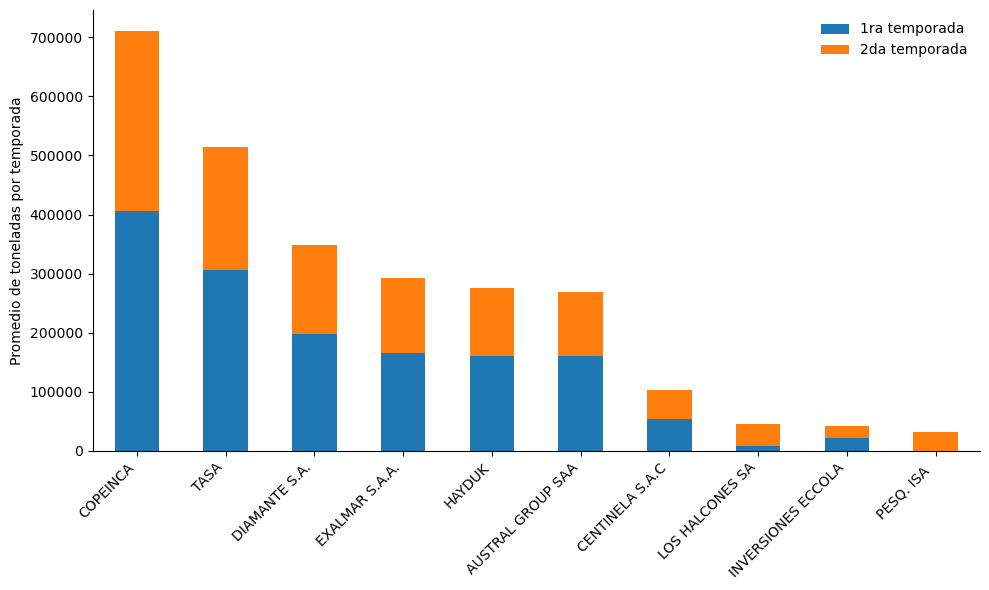

In [6]:

top_n = 10

df_plot = (
    promedios_empresas.copy()
    .replace({r"\.": "", "": None}, regex=True)
    .apply(pd.to_numeric, errors="coerce")
    .head(top_n)
)

fig, ax = plt.subplots(figsize=(10, 6))
df_plot[["promedio_1ra", "promedio_2da"]].plot(
    kind="bar",
    stacked=True,
    color=["#1f77b4", "#ff7f0e"],
    ax=ax
)

ax.set_ylabel("Promedio de toneladas por temporada")
ax.set_xlabel("")
ax.legend(["1ra temporada", "2da temporada"], frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()